In [25]:
# =============================================================================
# 1. Import Necessary Libraries
# =============================================================================
import numpy as np
import pandas as pd
import shap
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [ ]:
# Set alternative plotting style and parameters
plt.style.use("seaborn-v0_8-white")
sns.set_theme(style="whitegrid", palette="cubehelix")
plt.rcParams['figure.figsize'] = (10, 6)


In [ ]:
# =============================================================================
# 2. Data Loading and Preprocessing
# =============================================================================
# Load the Adult dataset (assumed saved as 'adult.csv')
df = pd.read_csv("adult.csv")

In [ ]:
# Display basic dataset information
print("Dataset Shape:", df.shape)
print("\nDataset Preview:")
df.head()

Dataset Shape: (48842, 15)

Dataset Preview:


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [ ]:
print("\nData Info:")
df.info()


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [ ]:
print("\nMissing Values per Column:")
df.isnull().sum()


Missing Values per Column:


,0
age,0
workclass,0
fnlwgt,0
education,0
educational-num,0
marital-status,0
occupation,0
relationship,0
race,0
gender,0


In [ ]:
# For simplicity, assume that missing values (if any) in numerical columns are replaced by median,
# and categorical columns by mode.
# Define feature lists based on typical Adult dataset columns.
# (Modify the column names based on your actual dataset if necessary.)
numerical_features = ["age", "fnlwgt", "educational-num", "capital-gain", "capital-loss", "hours-per-week"]
categorical_features = [col for col in df.columns if col not in numerical_features + ["income"]]

In [ ]:
# Fill missing values for numerical features
for col in numerical_features:
    df[col].fillna(df[col].median(), inplace=True)
# Fill missing values for categorical features
for col in categorical_features:
    df[col].fillna(df[col].mode()[0], inplace=True)


<ipython-input-12-a47d3eec26a6>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
<ipython-input-12-a47d3eec26a6>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [ ]:
# Convert target: income (assumed values: '>50K' and '<=50K') to binary (1 for >50K, 0 for <=50K)
df["income"] = df["income"].map({">50K": 1, "<=50K": 0})
target = "income"

In [ ]:
# Preprocessing: one-hot encode categorical features and scale numerical features.
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features)
    ]
)
X_processed = preprocessor.fit_transform(df.drop(columns=[target]))
y = df[target].astype(int)

In [ ]:
# Retrieve feature names for visualization
ohe = preprocessor.named_transformers_["cat"]
ohe_feature_names = ohe.get_feature_names_out(categorical_features)
all_features = np.concatenate([numerical_features, ohe_feature_names])
X_df = pd.DataFrame(X_processed.toarray() if hasattr(X_processed, "toarray") else X_processed, columns=all_features)
print("\nProcessed Feature Columns:")
print(X_df.columns)


Processed Feature Columns:
Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Never-worked', 'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'education_11th', 'education_12th',
       'education_1st-4th', 'education_5th-6th', 'education_7th-8th',
       'education_9th', 'education_Assoc-acdm', 'education_Assoc-voc',
       'education_Bachelors', 'education_Doctorate', 'education_HS-grad',
       'education_Masters', 'education_Preschool', 'education_Prof-school',
       'education_Some-college', 'marital-status_Married-AF-spouse',
       'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occ

In [16]:
# =============================================================================
# 3. Train-Test Split
# =============================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=0.20, random_state=42, stratify=y
)
print("\nTraining Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)



Training Set Shape: (39073, 100)
Test Set Shape: (9769, 100)


In [17]:
# =============================================================================
# 4. Stacking Ensemble Model Training using GridSearchCV
# =============================================================================
# Define base estimators
base_estimators = [
    ("lr", LogisticRegression(max_iter=1000, random_state=42)),
    ("rf", RandomForestClassifier(random_state=42)),
    ("xgb", XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42))
]


In [19]:
# Meta-learner: Logistic Regression
stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5,
    n_jobs=-1,
    passthrough=True
)

# Hyperparameter grid for the meta-learner can be tuned along with some base estimator parameters.
param_grid = {
    "final_estimator__C": [0.1, 1.0, 10.0],
    "rf__n_estimators": [100, 150],
    "xgb__max_depth": [3, 5],
    "xgb__learning_rate": [0.05, 0.1]
}

grid = GridSearchCV(estimator=stacking_clf, param_grid=param_grid, scoring="accuracy", cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print("\nBest Parameters:", grid.best_params_)
print("Best Cross-Validation Accuracy:", grid.best_score_)

best_model = grid.best_estimator_

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best Parameters: {'final_estimator__C': 1.0, 'rf__n_estimators': 100, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 5}
Best Cross-Validation Accuracy: 0.8733905300802848


In [20]:
# =============================================================================
# 5. Model Evaluation
# =============================================================================
y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Probability for positive class
y_pred = best_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7431
           1       0.79      0.66      0.72      2338

    accuracy                           0.88      9769
   macro avg       0.84      0.80      0.82      9769
weighted avg       0.87      0.88      0.87      9769

Confusion Matrix:
[[7014  417]
 [ 795 1543]]


In [21]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.928136863132838


In [22]:
# =============================================================================
# 6. Visualizations
# =============================================================================

## 6.1 Interactive ROC Curve using Plotly Express
roc_df = pd.DataFrame({"FPR": fpr, "TPR": tpr})
fig_px = px.line(roc_df, x="FPR", y="TPR", title=f"Interactive ROC Curve (AUC = {roc_auc:.3f})", markers=True)
fig_px.add_scatter(x=[0, 1], y=[0, 1], mode="lines", name="Baseline", line=dict(dash="dot", color="gray"))
fig_px.update_layout(xaxis_title="False Positive Rate", yaxis_title="True Positive Rate")
fig_px.show()

In [23]:
## 6.2 Stacked Bar Chart for Confusion Matrix
cm_df = pd.DataFrame(cm, index=["Actual <=50K", "Actual >50K"], columns=["Predicted <=50K", "Predicted >50K"])
cm_df_long = cm_df.reset_index().melt(id_vars="index", var_name="Prediction", value_name="Count")
cm_df_long.rename(columns={"index": "Actual"}, inplace=True)
fig_bar = px.bar(cm_df_long, x="Actual", y="Count", color="Prediction", title="Stacked Bar Chart of Confusion Matrix", text="Count")
fig_bar.update_layout(barmode="stack")
fig_bar.show()


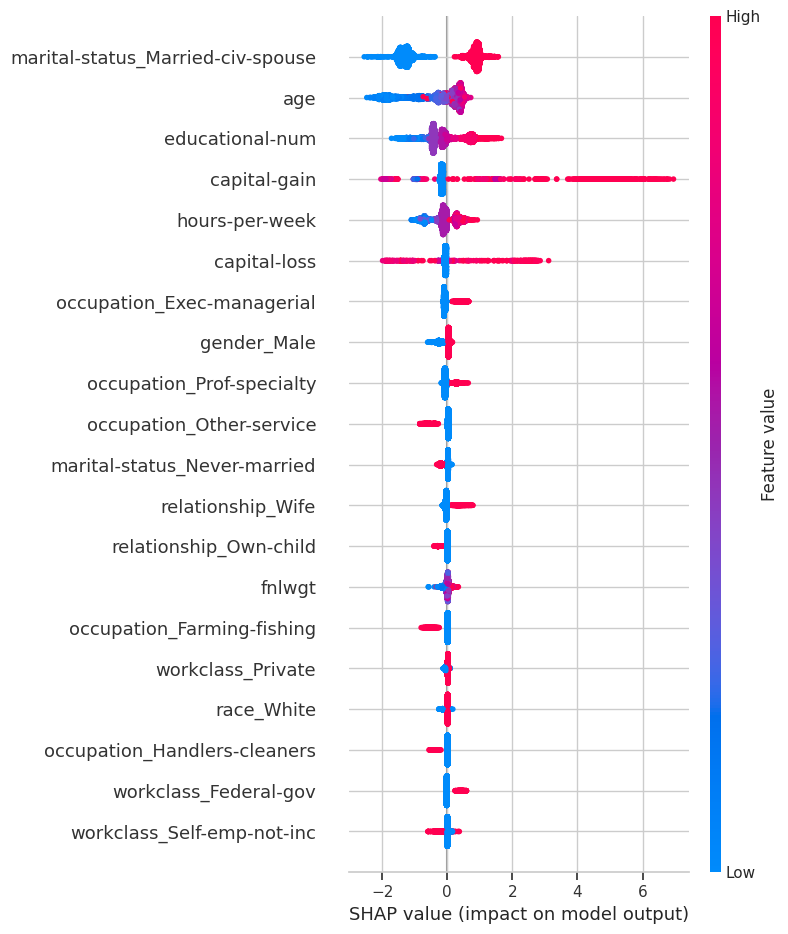

In [26]:
## 6.3 SHAP Beeswarm Plot for Feature Importance
explainer = shap.TreeExplainer(best_model.named_estimators_["xgb"])  # Using XGBoost base learner for SHAP
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="dot")


In [27]:
## 6.4 Smoothed Learning Curve using Gaussian Filter (Simulated)
# As stacking ensemble does not yield a traditional learning curve, we simulate dummy loss values.
epochs = np.arange(1, 11)
dummy_train_loss = np.linspace(0.80, 0.65, num=10)
dummy_val_loss = np.linspace(0.82, 0.66, num=10)
smoothed_train_loss = gaussian_filter1d(dummy_train_loss, sigma=1)
smoothed_val_loss = gaussian_filter1d(dummy_val_loss, sigma=1)


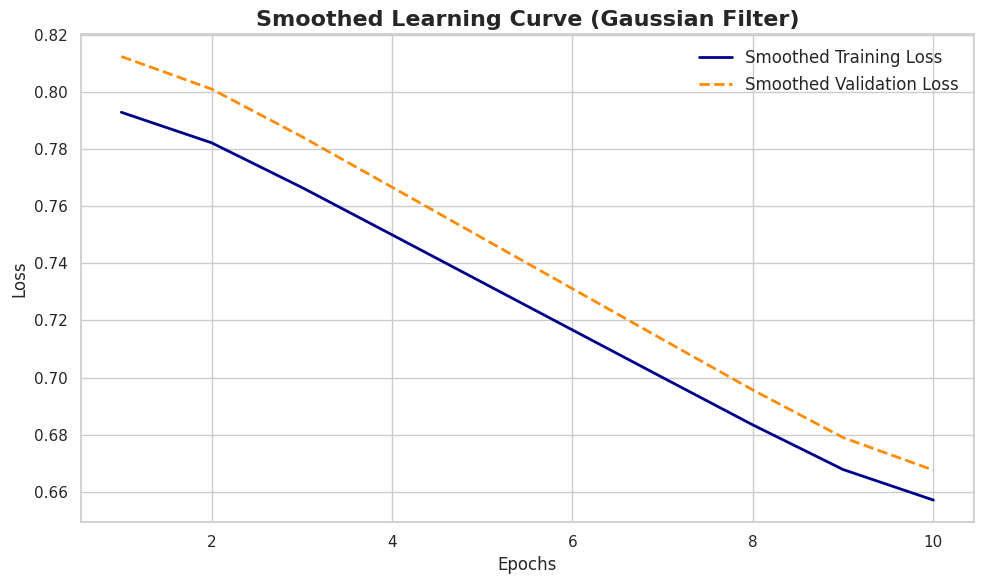

In [28]:
plt.figure(figsize=(10,6))
plt.plot(epochs, smoothed_train_loss, label="Smoothed Training Loss", color="darkblue", lw=2)
plt.plot(epochs, smoothed_val_loss, label="Smoothed Validation Loss", color="darkorange", lw=2, linestyle="--")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Smoothed Learning Curve (Gaussian Filter)", fontsize=16, fontweight="bold")
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()